In [116]:
# !pip install cplex
# !pip install docplex
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from tqdm.notebook import tqdm

In [117]:
# Initialize parameters
var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
var_high = 6e9  # Upper bound of qubit frequencies (in Hz)


def solve_model_with_delta(delta_Q_2, Delta_Q, N):
    """Solve the model for a given delta_Q^(2) and return the solution and differences if it exists."""
    # Create a new model using DOcplex MP
    model = Model(name="maximize_qubit_interaction_separation")

    # Define qubit frequencies (continuous variables between var_low and var_high)
    qubit_freqs = model.continuous_var_list(N, lb=var_low, ub=var_high, name="q")

    # Enforce that qubit frequencies are in increasing order and have a minimum separation of Delta_Q
    for i in range(N - 1):
        model.add_constraint(qubit_freqs[i] + Delta_Q <= qubit_freqs[i + 1])

    # Define a list to store the interaction frequency separations (delta_Q^(2)) for all possible pairs
    interaction_diffs = []
    for i in range(N):
        for j in range(i + 1, N):
            interaction_diffs.append(qubit_freqs[j] - qubit_freqs[i])

    # Now, add constraints to ensure abs(delta_Q^(2)_i - delta_Q^(2)_j) >= delta_Q_2 for all pairs of interaction separations
    for i in range(len(interaction_diffs)):
        for j in range(i + 1, len(interaction_diffs)):
            model.add_constraint(
                model.abs(interaction_diffs[i] - interaction_diffs[j]) >= delta_Q_2
            )

    # Solve the model
    solution = model.solve()

    # Return the solution and interaction frequency separations if the solution exists
    if solution:
        qubit_values = [qubit_freqs[i].solution_value for i in range(N)]
        interaction_values = sorted([diff.solution_value for diff in interaction_diffs])
        return True, qubit_values, interaction_values
    else:
        return False, None, None


def binary_search_delta(min_delta, max_delta, Delta_Q, N, tol=1e-3):
    """Perform a binary search to find the maximum delta_Q^(2) for which a solution exists."""
    best_delta_Q_2 = min_delta

    while max_delta - min_delta > tol:
        mid_delta = (min_delta + max_delta) / 2
        solution_exists, _, _ = solve_model_with_delta(mid_delta, Delta_Q, N)

        if solution_exists:
            best_delta_Q_2 = (
                mid_delta  # This is a valid solution, so we update the best delta_Q_2
            )
            min_delta = mid_delta  # Try larger delta_Q_2
        else:
            max_delta = mid_delta  # Try smaller delta_Q_2

    return best_delta_Q_2


def collect_data_for_N_values(N_values, Delta_Q_range):
    """Collects the data for different values of N and Delta_Q."""
    results = {}

    # Loop over different values of N
    for N in N_values:
        # Store the best delta_Q^(2) values for each Delta_Q
        best_delta_Q_2_values = []

        # Perform binary search for each Delta_Q to find the best delta_Q^(2)
        for Delta_Q in tqdm(Delta_Q_range):
            best_delta_Q_2 = binary_search_delta(
                0.0, (var_high - var_low) / (N - 1), Delta_Q, N
            )
            # Only append the result if a solution exists (best_delta_Q_2 > 0)
            if best_delta_Q_2 > 0:
                best_delta_Q_2_values.append((Delta_Q, best_delta_Q_2))

        # Store results for this N
        if best_delta_Q_2_values:
            results[N] = best_delta_Q_2_values

    return results

In [118]:
# Assuming the data collection and results generation has already been done:
num_qubits = [4, 5, 6]
Delta_Q_range = np.linspace(100e6, 600e6, 16)
results = collect_data_for_N_values(num_qubits, Delta_Q_range)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Saved: /home/evm9/quantum_logical/docs/images/delta_vs_Separation.pdf


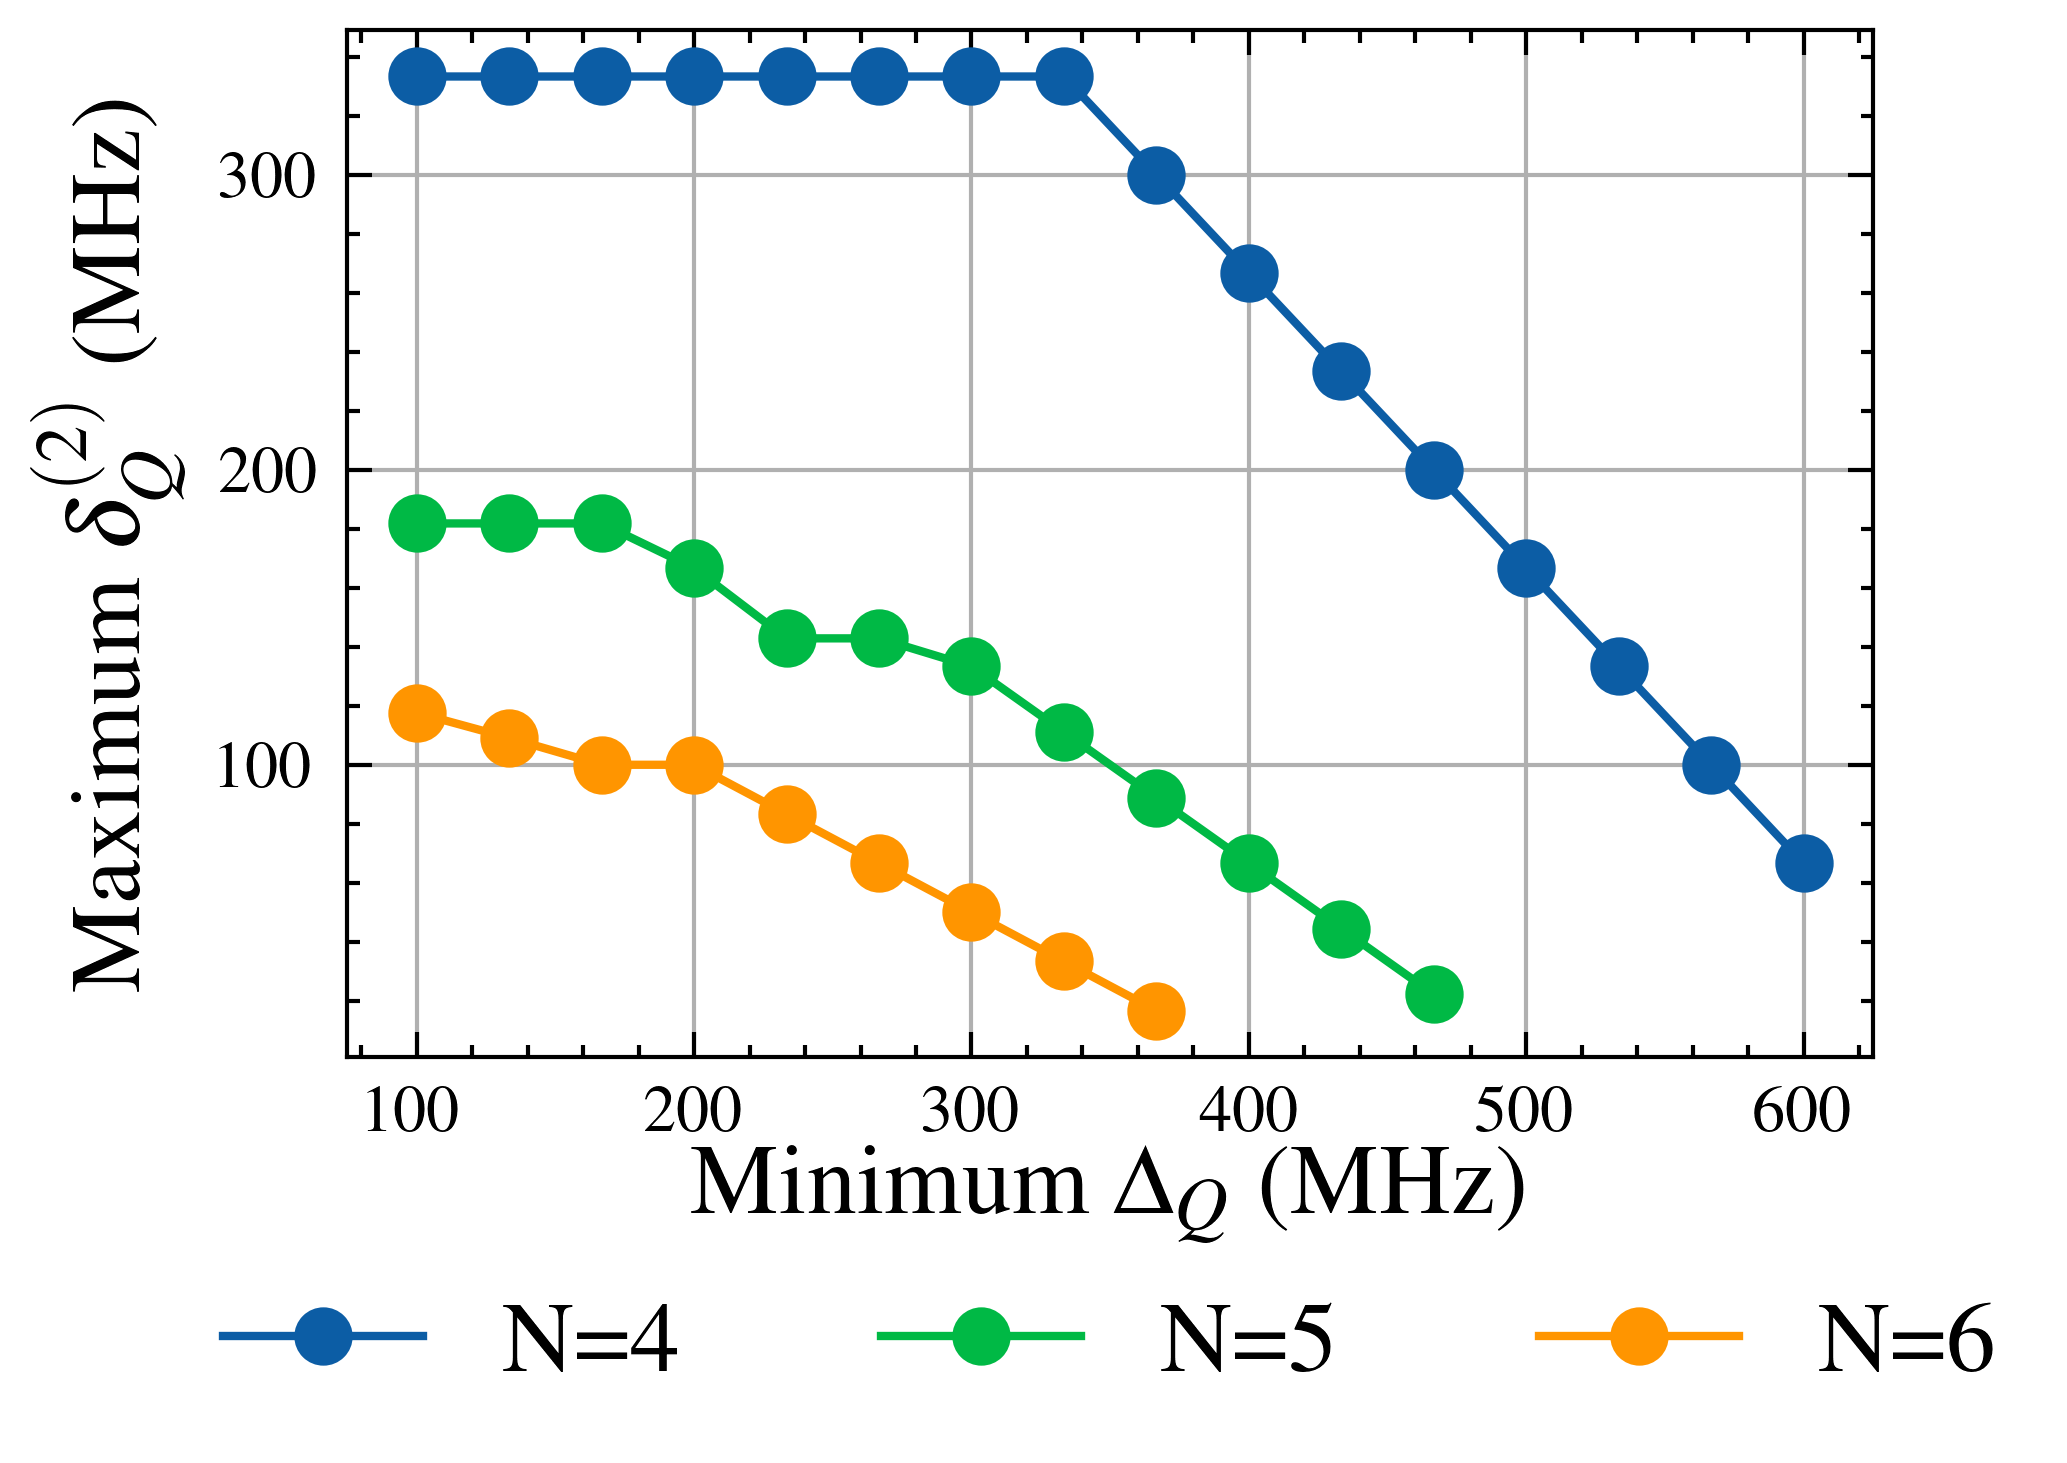

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import lovelyplots


def plot_results(results):
    """Plots the data stored in results with a consistent style."""

    # Plot the results using consistent style
    with plt.style.context(
        ["ieee", "use_mathtext", "science"]
    ):  # Using consistent style context
        fig, ax1 = plt.subplots()  # Adjust figure size

        # Loop over each set of results to plot separate lines for different N values
        for N, data in results.items():
            # Extract Delta_Q and delta_Q^(2) where solution exists
            Delta_Q_values, best_delta_Q_2_plot = zip(*data)

            # Plotting delta_Q^(2) vs Delta_Q, converting units to GHz and MHz
            ax1.plot(
                np.array(Delta_Q_values) / 1e6,  # Convert Delta_Q to GHz
                np.array(best_delta_Q_2_plot) / 1e6,  # Convert delta_Q^(2) to MHz
                marker="o",
                label=f"N={N}",
            )

        # Labels for the main plot
        ax1.set_xlabel(
            r"Minimum $\Delta_Q$ (MHz)",
            fontsize=12,
            labelpad=-0.25,
        )
        ax1.set_ylabel(
            r"Maximum $\delta_Q^{(2)}$ (MHz)",
            fontsize=12,
        )
        # ax1.set_title(
        #     r"Maximum $\delta_Q^{(2)}$ (MHz) vs $\Delta_Q$ (GHz) for Different N",
        #     fontsize=16,
        # )

        # Grid, legend, and layout adjustments
        ax1.grid(True)
        ax1.legend(
            fontsize=12,
            # title="\# of qubits",
            title_fontsize=12,
            loc="upper center",
            ncols=3,
            bbox_to_anchor=(0.5, -0.15),
        )
        fig.tight_layout()

        # less tick marks on the edges
        ax1.locator_params(axis="x", nbins=6)
        ax1.locator_params(axis="y", nbins=6)

        # Save the plot as an SVG file
        plot_filename = "/home/evm9/quantum_logical/docs/images/delta_vs_Separation.pdf"
        plt.savefig(plot_filename)
        print(f"Saved: {plot_filename}")
        plt.show()


# Plot the results with consistent style
plot_results(results)

In [161]:
var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
var_high = 5e9  # Upper bound of qubit frequencies (in Hz)
ret = solve_model_with_delta(150e6, 180e6, 4)
print(ret)
qubits = np.array(ret[1]) / 1e9
print(qubits)
# print all pairs of qubit differences
convs = np.array(ret[2]) / 1e9
print(convs)

(True, [4000000000.0, 4330000000.0, 4810000000.0, 4990000000.0], [180000000.0, 330000000.0, 480000000.0, 660000000.0, 810000000.0, 990000000.0])
[4.   4.33 4.81 4.99]
[0.18 0.33 0.48 0.66 0.81 0.99]


In [145]:
var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
var_high = 6e9  # Upper bound of qubit frequencies (in Hz)
ret = solve_model_with_delta(200e6, 450e6, 4)
print(ret)
qubits = np.array(ret[1]) / 1e9
print(qubits)
# print all pairs of qubit differences
convs = np.array(ret[2]) / 1e9
print(convs)

(True, [4000000000.0, 4850000000.0, 5500000000.0, 5950000000.0], [450000000.0, 650000000.0, 850000000.0, 1100000000.0, 1500000000.0, 1950000000.0])
[4.   4.85 5.5  5.95]
[0.45 0.65 0.85 1.1  1.5  1.95]


In [122]:
ret = solve_model_with_delta(180e6, 100e6, 5)
print(ret)
qubits = np.array(ret[1]) / 1e9
print(qubits)
# print all pairs of qubit differences
convs = np.array(ret[2]) / 1e9
print(convs)

(True, [4000000000.0, 4360000000.0, 5260000000.0, 5800000000.0, 5980000000.0], [180000000.0, 360000000.0, 540000000.0, 720000000.0, 900000000.0, 1260000000.0, 1440000000.0, 1620000000.0, 1800000000.0, 1980000000.0])
[4.   4.36 5.26 5.8  5.98]
[0.18 0.36 0.54 0.72 0.9  1.26 1.44 1.62 1.8  1.98]
